In [198]:
import pandas as pd
import scipy
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

from autumn.tools.curve import scale_up_function

props_df = pd.DataFrame(
    { 
        "A":[1., .2, .2, .2], 
        "B":[0., .8, .6, .7], 
        "C":[0., .0, .2, .1]
    },
    index = [0, 100 , 150, 175]
)

active_flows = [
    "A_to_B", 
    "B_to_C", 
    "C_to_B"
]


def calculate_transition_rates_from_dynamic_props(props_df, active_flows):     
    
    strata = props_df.columns.to_list()
    times = props_df.index.to_list()
    
    tv_rates = {flow : [] for flow in active_flows}
    for i in range(len(times) - 1):
        delta_t = times[i + 1] - times[i]
        start_props = props_df.loc[times[i]]
        end_props = props_df.loc[times[i + 1]]
        
        rates = calculate_rates_for_interval(start_props, end_props, delta_t, strata, active_flows)      
        for i_flow, flow in enumerate(active_flows):
            tv_rates[flow].append(rates[i_flow])
    
    # create time-variant functions
    scaleup_times = [[t, t+1] for t in times]
    scaleup_times = [t for sublist in scaleup_times for t in sublist]  # to get a flat list
    
    scaleup_param_functions = {}
    for flow in active_flows:
        values = [[0.]] + [[v]*2 for v in tv_rates[flow]] + [[0.]]
        values = [v for sublist in values for v in sublist]   # to get a flat list        
        scaleup_param_functions[flow] = scale_up_function(scaleup_times, values, method=4)
                
    return scaleup_param_functions
        
    
def calculate_rates_for_interval(start_props, end_props, delta_t, strata, active_flows):
    n_strata = len(strata)
    n_params = len(active_flows)
    
    def function_to_zero(params):        
        # params are ordered in the same order as active_flows
       
        m = np.zeros((n_strata, n_strata))        
        
        for i_row, stratum_row in enumerate(strata):
            for i_col, stratum_col in enumerate(strata):
                if i_row == i_col:
                    relevant_flows = [f for f in active_flows if f.startswith(f"{stratum_row}_to_")]
                    for f in relevant_flows:
                        m[i_row, i_col] -= params[active_flows.index(f)]
                else:
                    potential_flow = f"{stratum_col}_to_{stratum_row}"
                    if potential_flow in active_flows:
                        m[i_row, i_col] = params[active_flows.index(potential_flow)]
                        
        exp_mt = scipy.linalg.expm(m * delta_t)
        diff = np.matmul(exp_mt, start_props) - end_props
        
        return scipy.linalg.norm(diff)    
    
    bounds = [(0., None)] * n_params
    
    solution = minimize(function_to_zero, x0=np.zeros(n_params), bounds=bounds, method="TNC")  
    
    return solution.x
        
sc_functions = calculate_transition_rates_from_dynamic_props(props_df, active_flows)

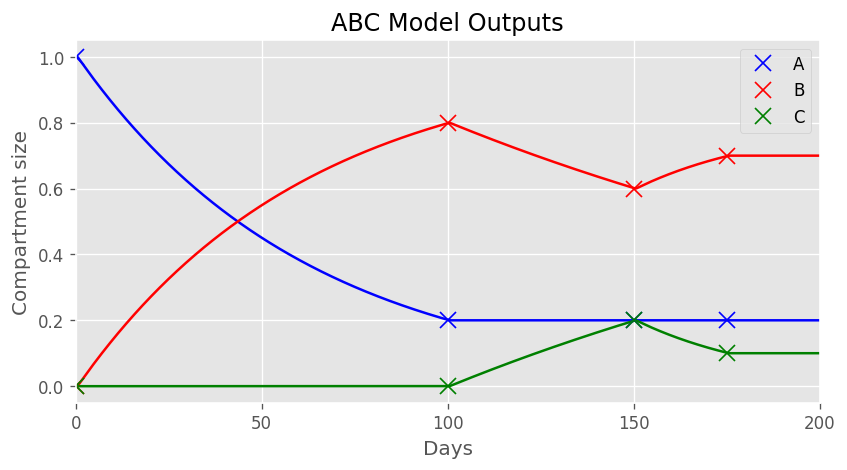

In [199]:
from summer import CompartmentalModel

# Define the model
model = CompartmentalModel(
    times=[0, 200],
    compartments=["A", "B", "C"],
    infectious_compartments=["A"],
    timestep=0.1,
)

model.set_initial_population(distribution={"A": 1})

model.add_transition_flow(name="A_to_B", fractional_rate=sc_functions["A_to_B"], source="A", dest="B")
model.add_transition_flow(name="B_to_C", fractional_rate=sc_functions["B_to_C"], source="B", dest="C")
model.add_transition_flow(name="C_to_B", fractional_rate=sc_functions["C_to_B"], source="C", dest="B")

model.run()


# Visualize the results.
subplot = {"title": "ABC Model Outputs", "xlabel": "Days", "ylabel": "Compartment size"}
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=120, subplot_kw=subplot)
colors = ["blue", "red", "green"]

plt.style.use("ggplot")
ax.legend(["A", "B", "C"])
for compartment_idx in range(model.outputs.shape[1]):
    ax.plot(model.times, model.outputs.T[compartment_idx], color=colors[compartment_idx])

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start + 1, end, 5))


ax.set_xticks([0,50,100,150,200])

props_df.plot(ax=ax, marker="x", ms=10, lw=0, color=colors)

plt.show()